In [1]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
import os
from datetime import datetime
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
# Cell 2: Configuration parameters
# Input and output files
INPUT_FILE = 'processed_sentiment_data.csv'
OUTPUT_FILE = 'processed_data_best_corr_sentiment.csv'

# Analysis parameters
TARGET_COLUMN = 'BRENT Close'
LAG_DAYS = 1  # For lagged correlation calculation
FORECAST_HORIZON = 1  # Days ahead to predict
N_SPLITS = 5  # Number of time-series cross-validation splits

# Model selection
MODELS_TO_TRY = ['lasso', 'ridge', 'randomforest', 'gbm']
BEST_MODEL = 'lasso'  # Default model to use for feature selection

# Visualization options
VISUALIZE = True
SAVE_PLOTS = False

In [3]:
# Cell 3: Helper functions for data loading and inspection
def load_data(file_path):
    """Load data from CSV file and process dates."""
    try:
        df = pd.read_csv(file_path)
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            # Set Date as index for time series analysis
            df = df.set_index('Date')
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def identify_sentiment_columns(df):
    """Identify daily and cumulative sentiment columns."""
    daily_sentiment_cols = [col for col in df.columns if 'Daily_Sum_' in col]
    cumulative_sentiment_cols = [col for col in df.columns if 'Csum_' in col]
    all_sentiment_cols = daily_sentiment_cols + cumulative_sentiment_cols
    
    print(f"Found {len(daily_sentiment_cols)} daily sentiment columns.")
    print(f"Found {len(cumulative_sentiment_cols)} cumulative sentiment columns.")
    
    return daily_sentiment_cols, cumulative_sentiment_cols, all_sentiment_cols

def inspect_data_quality(df, target_col, sentiment_cols):
    """Inspect data quality issues."""
    print("\n--- Data Quality Inspection ---")
    
    # Check for missing values
    missing_vals = df[sentiment_cols + [target_col]].isnull().sum()
    print("\nMissing values:")
    print(missing_vals[missing_vals > 0])
    
    # Check for infinity or extreme values
    has_inf = np.isinf(df[sentiment_cols + [target_col]].values).any()
    if has_inf:
        print("\nWarning: Infinity values detected in the data")
    
    # Check data types
    print("\nData types:")
    print(df[sentiment_cols + [target_col]].dtypes)
    
    # Basic statistics
    print("\nBasic statistics for target variable:")
    display(df[target_col].describe())
    
    return df

In [4]:
# Cell 4: Feature evaluation functions
def calculate_basic_metrics(df, sentiment_cols, daily_cols, target_col, lag_days):
    """Calculate correlation and mutual information metrics."""
    # Create basic metrics dictionary
    metrics = {
        'contemp_corr': {},
        'lagged_corr': {},
        'mutual_info': {}
    }
    
    for col in sentiment_cols:
        if col in df.columns:
            # Contemporaneous correlation
            metrics['contemp_corr'][col] = df[col].corr(df[target_col])
            
            # Mutual Information
            X_mi = df[col].values.reshape(-1, 1)
            y_mi = df[target_col].values
            mi = mutual_info_regression(X_mi, y_mi, discrete_features=False, random_state=42)
            metrics['mutual_info'][col] = mi[0]
    
    # Lagged correlation (only for daily sentiment)
    for col in daily_cols:
        if col in df.columns:
            lagged_series = df[col].shift(lag_days)
            metrics['lagged_corr'][col] = lagged_series.corr(df[target_col])
    
    return metrics

def prepare_lagged_features(df, sentiment_cols, target_col, forecast_horizon=1):
    """Prepare dataset with lagged features for predictive modeling."""
    # Create a copy of the dataframe to avoid modifying the original
    df_model = df.copy()
    
    # Create the target variable (future price)
    df_model['target'] = df_model[target_col].shift(-forecast_horizon)
    
    # Create lagged features
    lagged_features = []
    for col in sentiment_cols:
        # Current value
        lagged_features.append(col)
        
        # Add 1-day and 2-day lagged values for each sentiment
        lag_col_1 = f"{col}_lag1"
        df_model[lag_col_1] = df_model[col].shift(1)
        lagged_features.append(lag_col_1)
        
        lag_col_2 = f"{col}_lag2"
        df_model[lag_col_2] = df_model[col].shift(2)
        lagged_features.append(lag_col_2)
    
    # Add lagged target variables
    target_lag_1 = f"{target_col}_lag1"
    df_model[target_lag_1] = df_model[target_col].shift(1)
    lagged_features.append(target_lag_1)
    
    target_lag_2 = f"{target_col}_lag2"
    df_model[target_lag_2] = df_model[target_col].shift(2)
    lagged_features.append(target_lag_2)
    
    # Drop rows with NaN values (due to lagging)
    df_model = df_model.dropna()
    
    return df_model, lagged_features

def evaluate_model_performance(df_model, features, target='target', model_type='lasso', n_splits=5):
    """Evaluate model performance using time series cross-validation."""
    # Prepare data
    X = df_model[features]
    y = df_model[target]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create time series cross-validation splits
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Initialize model based on type
    if model_type == 'lasso':
        model = LassoCV(cv=5, random_state=42, max_iter=2000)
    elif model_type == 'ridge':
        model = RidgeCV(cv=5)
    elif model_type == 'randomforest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'gbm':
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    else:
        model = LinearRegression()
    
    # Perform time series cross-validation
    cv_scores = {
        'mse': [],
        'rmse': [],
        'mae': [],
        'r2': []
    }
    
    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        cv_scores['mse'].append(mse)
        cv_scores['rmse'].append(np.sqrt(mse))
        cv_scores['mae'].append(mean_absolute_error(y_test, y_pred))
        cv_scores['r2'].append(r2_score(y_test, y_pred))
    
    # Average scores
    avg_scores = {metric: np.mean(scores) for metric, scores in cv_scores.items()}
    
    # Get feature importances
    if model_type in ['lasso', 'ridge']:
        # For linear models, get coefficients
        try:
            if model_type == 'lasso':
                coefs = model.coef_
            else:
                coefs = model.coef_
            feature_importances = {feature: abs(coef) for feature, coef in zip(features, coefs)}
        except:
            # If model has not been properly fitted
            feature_importances = {feature: 0 for feature in features}
    elif model_type in ['randomforest', 'gbm']:
        # For tree-based models, get feature importances
        model.fit(X_scaled, y)  # Fit on full dataset for feature importance
        feature_importances = {feature: imp for feature, imp in zip(features, model.feature_importances_)}
    else:
        # Default to a simple linear regression for coefficients
        lr = LinearRegression().fit(X_scaled, y)
        feature_importances = {feature: abs(coef) for feature, coef in zip(features, lr.coef_)}
    
    return avg_scores, feature_importances, model

In [5]:
# Cell 5: Optimization and sentiment selection functions
def find_best_model(df_model, features, models_to_try, target='target', n_splits=5):
    """Find the best model for prediction based on cross-validation."""
    model_scores = {}
    
    print("\n--- Model Evaluation ---")
    for model_type in models_to_try:
        print(f"Evaluating {model_type}...")
        scores, _, _ = evaluate_model_performance(
            df_model, features, target, model_type, n_splits
        )
        model_scores[model_type] = scores
        print(f"  RMSE: {scores['rmse']:.4f}, R²: {scores['r2']:.4f}")
    
    # Find best model based on RMSE
    best_model = min(model_scores.items(), key=lambda x: x[1]['rmse'])
    print(f"\nBest model: {best_model[0]} (RMSE: {best_model[1]['rmse']:.4f}, R²: {best_model[1]['r2']:.4f})")
    
    return best_model[0]

def select_best_sentiment(df_full, all_sentiment_cols, daily_cols, target_col, 
                          lag_days=1, forecast_horizon=1, 
                          best_model='lasso', n_splits=5):
    """Select the best sentiment indicator using optimization techniques."""
    print("\n--- Advanced Sentiment Selection ---")
    
    # Clean data for modeling
    df_clean = df_full.copy()
    # Drop any rows with NaN in target column
    df_clean = df_clean.dropna(subset=[target_col]) 
    
    # Calculate basic metrics
    basic_metrics = calculate_basic_metrics(df_clean, all_sentiment_cols, daily_cols, target_col, lag_days)
    
    # Create results dataframe from basic metrics
    results_df = pd.DataFrame(index=all_sentiment_cols)
    results_df['Contemp_Corr'] = results_df.index.map(basic_metrics['contemp_corr'])
    results_df['Lagged_Corr'] = results_df.index.map(basic_metrics['lagged_corr'])
    results_df['Mutual_Info'] = results_df.index.map(basic_metrics['mutual_info'])
    
    # Display top sentiment indicators by basic metrics
    print("\nTop 5 sentiment indicators by absolute contemporaneous correlation:")
    display(results_df.sort_values('Contemp_Corr', key=abs, ascending=False).head(5))
    
    # Prepare data for predictive modeling
    df_model, lagged_features = prepare_lagged_features(
        df_clean, all_sentiment_cols, target_col, forecast_horizon
    )
    
    # Evaluate feature importance using the specified model
    print(f"\nEvaluating feature importance using {best_model}...")
    _, feature_importances, model = evaluate_model_performance(
        df_model, lagged_features, 'target', best_model, n_splits
    )
    
    # Convert to DataFrame for sorting
    importance_df = pd.DataFrame({
        'Feature': list(feature_importances.keys()),
        'Importance': list(feature_importances.values())
    }).sort_values('Importance', ascending=False)
    
    # Display top features by importance
    print("\nTop 10 features by importance:")
    display(importance_df.head(10))
    
    # Identify best sentiment columns
    # First, filter to only original sentiment columns (not lagged versions)
    orig_sentiment_importances = {
        feat: imp for feat, imp in feature_importances.items() 
        if feat in all_sentiment_cols
    }
    
    if orig_sentiment_importances:
        # Get the best sentiment column
        best_sentiment_col = max(orig_sentiment_importances.items(), key=lambda x: x[1])[0]
        print(f"\nBest sentiment indicator (by predictive importance): {best_sentiment_col}")
        
        # Create a more comprehensive evaluation for the best sentiment
        print("\nComprehensive evaluation of the best sentiment indicator:")
        sentiment_eval = {
            'Column': best_sentiment_col,
            'Feature Importance': orig_sentiment_importances[best_sentiment_col],
            'Contemporaneous Correlation': basic_metrics['contemp_corr'].get(best_sentiment_col, np.nan),
            'Lagged Correlation': basic_metrics['lagged_corr'].get(best_sentiment_col, np.nan),
            'Mutual Information': basic_metrics['mutual_info'].get(best_sentiment_col, np.nan)
        }
        display(pd.DataFrame([sentiment_eval]))
        
        return best_sentiment_col, model, importance_df
    else:
        print("Warning: No sentiment indicators found with non-zero importance.")
        # Fall back to correlation-based selection
        best_col = results_df.sort_values('Contemp_Corr', key=abs, ascending=False).index[0]
        print(f"Falling back to best indicator by correlation: {best_col}")
        return best_col, model, importance_df

def visualize_feature_importance(importance_df, top_n=15):
    """Visualize feature importance from model."""
    plt.figure(figsize=(12, 8))
    
    # Get top N features
    top_features = importance_df.head(top_n)
    
    # Create horizontal bar chart
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [6]:
# Cell 6: Data preprocessing and visualization functions
def visualize_results(df, target_col, best_sentiment_col, save_plots=False):
    """Visualize the target vs. the best sentiment indicator."""
    print("Visualizing the best sentiment indicator...")
    
    # Create a clean copy for visualization
    df_viz = df[[target_col, best_sentiment_col]].dropna().copy()
    
    if not df_viz.empty:
        # Scale data for better visualization
        scaler_viz = MinMaxScaler()
        df_viz_scaled = pd.DataFrame(
            scaler_viz.fit_transform(df_viz), 
            columns=df_viz.columns, 
            index=df_viz.index
        )
        
        # Create plot
        plt.figure(figsize=(14, 7))
        plt.plot(df_viz_scaled.index, df_viz_scaled[target_col], label=f'{target_col} (Scaled)', alpha=0.8)
        plt.plot(df_viz_scaled.index, df_viz_scaled[best_sentiment_col], label=f'{best_sentiment_col} (Scaled)', alpha=0.7)
        plt.title(f'{target_col} vs. Best Sentiment Indicator: {best_sentiment_col}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # Save if requested
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            plot_path = f"sentiment_analysis_{timestamp}.png"
            plt.savefig(plot_path)
            print(f"Plot saved to {plot_path}")
        
        plt.show()
        
        # Also plot lagged relationship
        plt.figure(figsize=(10, 6))
        plt.scatter(df_viz[best_sentiment_col], df_viz[target_col], alpha=0.5)
        plt.title(f'Relationship between {best_sentiment_col} and {target_col}')
        plt.xlabel(best_sentiment_col)
        plt.ylabel(target_col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Plot autocorrelation
        from pandas.plotting import autocorrelation_plot
        plt.figure(figsize=(10, 6))
        autocorrelation_plot(df_viz[target_col])
        plt.title(f'Autocorrelation of {target_col}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    else:
        print("Warning: Not enough data for visualization.")

def filter_and_save_data(df_full, all_sentiment_cols, best_sentiment_col, output_file):
    """Filter out unwanted sentiment columns and save the data."""
    # Identify columns to remove (all sentiment columns except the best one)
    cols_to_remove = [col for col in all_sentiment_cols if col != best_sentiment_col]
    
    print(f"Keeping only the best sentiment: {best_sentiment_col}")
    print(f"Removing {len(cols_to_remove)} other sentiment columns.")
    
    # Use the originally loaded df_full to preserve all rows
    df_filtered = df_full.drop(columns=cols_to_remove, errors='ignore')
    
    print(f"Shape after removing columns: {df_filtered.shape}")
    print(f"Final columns: {df_filtered.columns.tolist()}")
    
    # Create output directory if needed
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save filtered data
    try:
        # Save with index
        df_filtered.to_csv(output_file)
        print(f"Filtered data saved to {output_file}")
        return df_filtered
    except Exception as e:
        print(f"Error saving data: {e}")
        return None

=== SENTIMENT ANALYSIS OPTIMIZATION PIPELINE ===
Input file: processed_sentiment_data.csv
Output file: processed_data_best_corr_sentiment.csv
Target column: BRENT Close
Lag days: 1
Forecast horizon: 1
Data loaded successfully. Shape: (2306, 42)

Preview of the data:


,BRENT Close,BRENT Volume,BRENT Price_Difference,BRENT Volume_Difference,USDX Close,USDX Price_Difference,Daily_Sum_RavenPack,Csum_RavenPack,Daily_Sum_FinBERT,Csum_FinBERT,...,BRENT Volume_minmax,Daily_Sum_RavenPack_minmax,Daily_Sum_FinBERT_minmax,Daily_Sum_CrudeBERT_minmax,Daily_Sum_CrudeBERT_GT_minmax,Daily_Sum_CrudeBERT_Plus_minmax,Daily_Sum_CrudeBERT_Plus_GT_minmax,BRENT Volume_log,BRENT Price_Difference_log,USDX Price_Difference_log
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,112.129997,1064.0,0.000000,0.0,79.610001,0.000000,0.33,1.89,0.5,-2.0,...,0.012204,0.469590,0.791667,0.491583,0.585115,0.517941,0.430841,6.970730,2.477378,1.214911
2012-01-04,113.699997,1426.0,1.570000,362.0,80.089996,0.479996,-0.06,1.83,1.5,-0.5,...,0.016356,0.414427,0.875000,0.407761,0.517977,0.587000,0.483587,7.263330,2.601207,1.348071
2012-01-05,112.739998,687.0,-0.959999,-739.0,80.940002,0.850006,0.49,2.32,2.0,1.5,...,0.007880,0.492221,0.916667,0.422580,0.528328,0.584835,0.481701,6.533789,2.393340,1.439835
2012-01-06,113.059998,709.0,0.320000,22.0,81.239998,0.299995,0.51,2.83,0.0,1.5,...,0.008132,0.495050,0.750000,0.430790,0.538532,0.599211,0.492542,6.565265,2.503892,1.300189
2012-01-09,112.449997,595.0,-0.610001,-114.0,81.050003,-0.189995,0.96,3.68,0.5,2.5,...,0.006825,0.558699,0.791667,0.474329,0.571842,0.620989,0.510292,6.390241,2.424803,1.156881


Found 18 daily sentiment columns.
Found 6 cumulative sentiment columns.

--- Data Quality Inspection ---

Missing values:
Series([], dtype: int64)

Data types:
Daily_Sum_RavenPack                   float64
Daily_Sum_FinBERT                     float64
Daily_Sum_CrudeBERT                   float64
Daily_Sum_CrudeBERT_GT                float64
Daily_Sum_CrudeBERT_Plus              float64
Daily_Sum_CrudeBERT_Plus_GT           float64
Daily_Sum_RavenPack_scaled            float64
Daily_Sum_FinBERT_scaled              float64
Daily_Sum_CrudeBERT_scaled            float64
Daily_Sum_CrudeBERT_GT_scaled         float64
Daily_Sum_CrudeBERT_Plus_scaled       float64
Daily_Sum_CrudeBERT_Plus_GT_scaled    float64
Daily_Sum_RavenPack_minmax            float64
Daily_Sum_FinBERT_minmax              float64
Daily_Sum_CrudeBERT_minmax            float64
Daily_Sum_CrudeBERT_GT_minmax         float64
Daily_Sum_CrudeBERT_Plus_minmax       float64
Daily_Sum_CrudeBERT_Plus_GT_minmax    float64
Csum_RavenPa

count    2306.000000
mean       71.868161
std        26.524931
min        19.330000
25%        50.790001
50%        63.610001
75%       103.147503
max       126.220001
Name: BRENT Close, dtype: float64


--- Model Evaluation ---
Evaluating lasso...
  RMSE: 1.8965, R²: 0.9642
Evaluating ridge...
  RMSE: 2.2375, R²: 0.9445
Evaluating randomforest...
  RMSE: 7.5699, R²: 0.4347
Evaluating gbm...
  RMSE: 7.9578, R²: 0.3676

Best model: lasso (RMSE: 1.8965, R²: 0.9642)

--- Advanced Sentiment Selection ---

Top 5 sentiment indicators by absolute contemporaneous correlation:


,Contemp_Corr,Lagged_Corr,Mutual_Info
Csum_CrudeBERT_Plus_GT,0.813416,NaN,1.513996
Csum_CrudeBERT_GT,0.751356,NaN,1.254978
Csum_FinBERT,0.655374,NaN,2.334921
Csum_CrudeBERT_Plus,0.653928,NaN,1.125400
Csum_RavenPack,-0.522063,NaN,1.460540



Evaluating feature importance using lasso...

Top 10 features by importance:


,Feature,Importance
72,BRENT Close_lag1,25.614842
73,BRENT Close_lag2,0.614394
69,Csum_CrudeBERT_Plus_GT,0.195049
0,Daily_Sum_RavenPack,0.014766
18,Daily_Sum_RavenPack_scaled,0.012169
71,Csum_CrudeBERT_Plus_GT_lag2,0.008057
36,Daily_Sum_RavenPack_minmax,0.004837
2,Daily_Sum_RavenPack_lag2,0.003106
38,Daily_Sum_RavenPack_minmax_lag2,0.000159
20,Daily_Sum_RavenPack_scaled_lag2,0.000003



Best sentiment indicator (by predictive importance): Csum_CrudeBERT_Plus_GT

Comprehensive evaluation of the best sentiment indicator:


,Column,Feature Importance,Contemporaneous Correlation,Lagged Correlation,Mutual Information
0,Csum_CrudeBERT_Plus_GT,0.195049,0.813416,NaN,1.513996


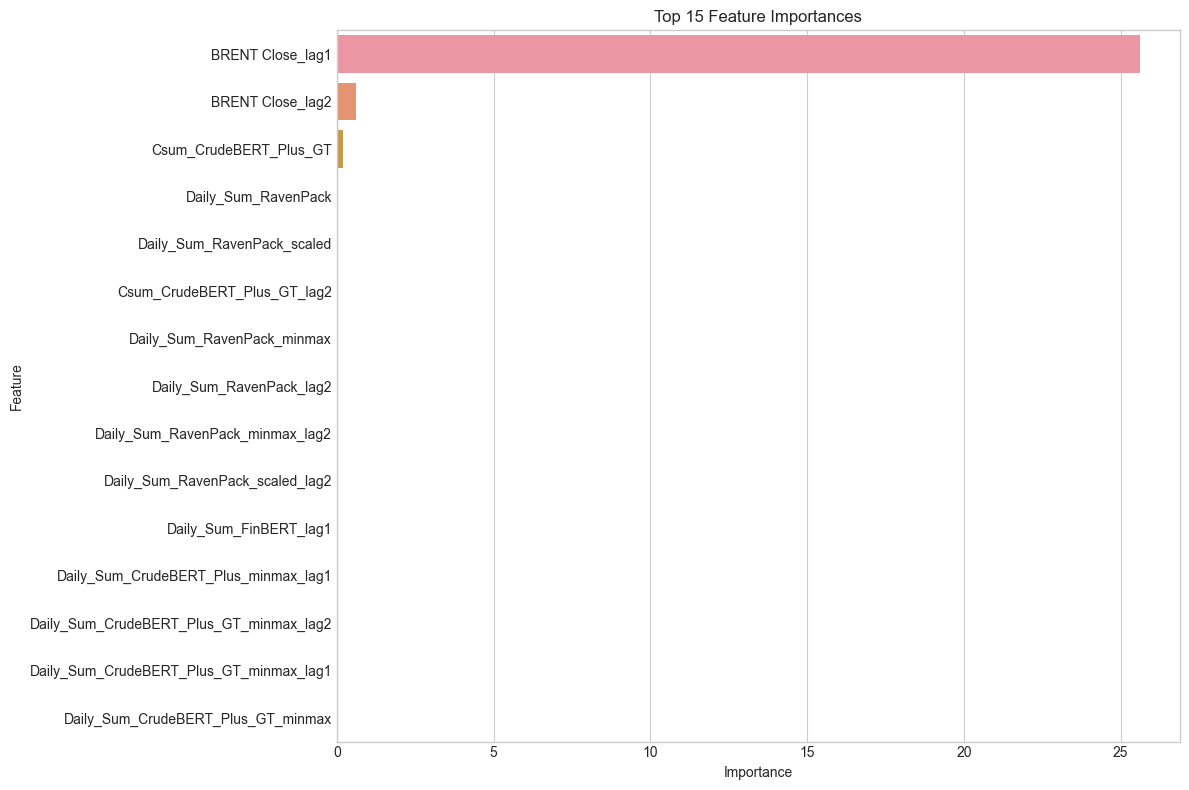

In [7]:
# Cell 7: Execute analysis pipeline
print("=== SENTIMENT ANALYSIS OPTIMIZATION PIPELINE ===")
print(f"Input file: {INPUT_FILE}")
print(f"Output file: {OUTPUT_FILE}")
print(f"Target column: {TARGET_COLUMN}")
print(f"Lag days: {LAG_DAYS}")
print(f"Forecast horizon: {FORECAST_HORIZON}")

# Load data
df_full = load_data(INPUT_FILE)
if df_full is None:
    raise ValueError(f"Could not load data from {INPUT_FILE}")

# Display the first few rows of the dataframe
print("\nPreview of the data:")
display(df_full.head())

# Identify sentiment columns
daily_cols, cumulative_cols, all_sentiment_cols = identify_sentiment_columns(df_full)
if not all_sentiment_cols:
    raise ValueError("No sentiment columns found (containing 'Daily_Sum_' or 'Csum_').")

# Check if target column exists
if TARGET_COLUMN not in df_full.columns:
    raise ValueError(f"Target column '{TARGET_COLUMN}' not found in the data.")

# Data quality inspection
df_full = inspect_data_quality(df_full, TARGET_COLUMN, all_sentiment_cols)

# Find best model if requested
if len(MODELS_TO_TRY) > 1:
    # Prepare data for predictive modeling
    df_clean = df_full.dropna(subset=[TARGET_COLUMN]).copy()
    df_model, lagged_features = prepare_lagged_features(
        df_clean, all_sentiment_cols, TARGET_COLUMN, FORECAST_HORIZON
    )
    BEST_MODEL = find_best_model(df_model, lagged_features, MODELS_TO_TRY, 'target', N_SPLITS)

# Find the best sentiment indicator using optimization
best_sentiment_col, model, importance_df = select_best_sentiment(
    df_full, all_sentiment_cols, daily_cols, TARGET_COLUMN, 
    LAG_DAYS, FORECAST_HORIZON, BEST_MODEL, N_SPLITS
)

# Visualize feature importance
visualize_feature_importance(importance_df)

Visualizing the best sentiment indicator...


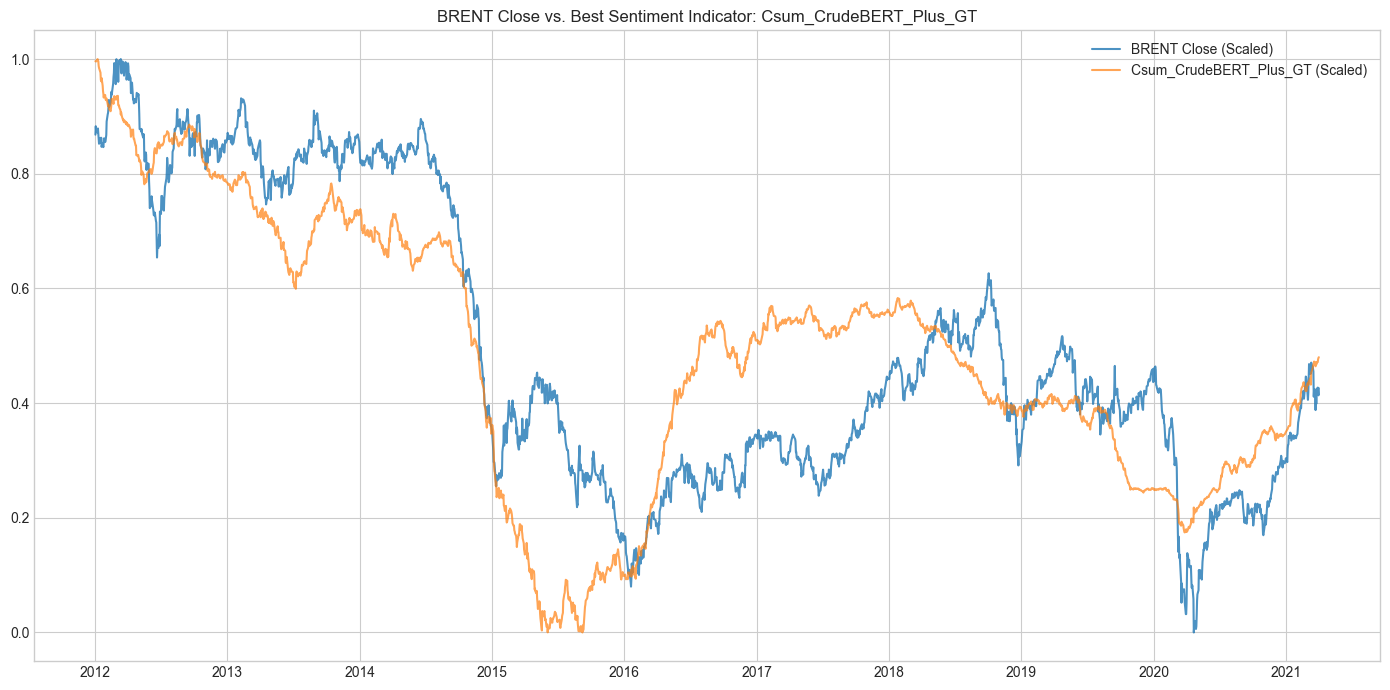

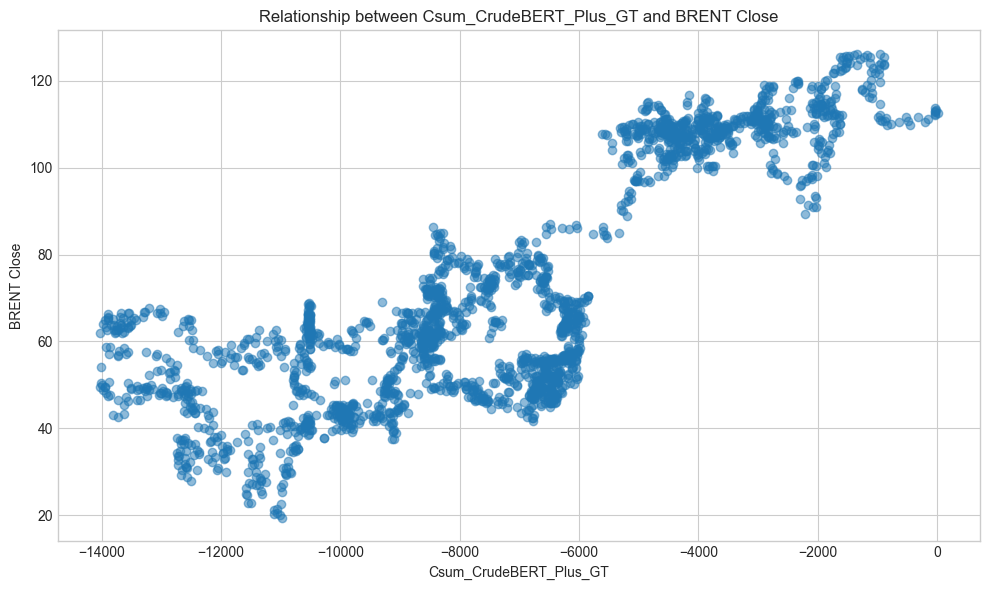

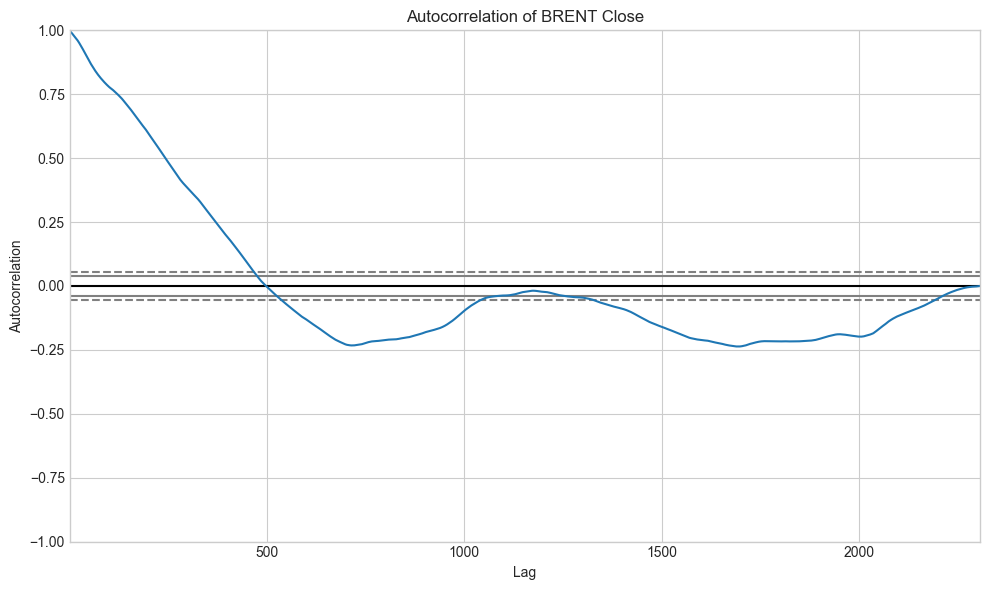


--- Forecast Evaluation with Best Sentiment ---
Forecast performance using only the best sentiment (Csum_CrudeBERT_Plus_GT):
  RMSE: 1.7566
  MAE: 1.2994
  R²: 0.9661


In [8]:
# Cell 8: Visualize and evaluate the best sentiment indicator
if VISUALIZE:
    visualize_results(df_full, TARGET_COLUMN, best_sentiment_col, SAVE_PLOTS)

# Perform a simple forecast evaluation with the best sentiment
print("\n--- Forecast Evaluation with Best Sentiment ---")
df_clean = df_full.dropna(subset=[TARGET_COLUMN]).copy()
df_model, _ = prepare_lagged_features(
    df_clean, [best_sentiment_col], TARGET_COLUMN, FORECAST_HORIZON
)

# Use only the best sentiment and its lags for prediction
best_features = [best_sentiment_col, f"{best_sentiment_col}_lag1", 
                f"{best_sentiment_col}_lag2", 
                f"{TARGET_COLUMN}_lag1", f"{TARGET_COLUMN}_lag2"]
best_features = [f for f in best_features if f in df_model.columns]

# Evaluate prediction performance
scores, _, _ = evaluate_model_performance(
    df_model, best_features, 'target', BEST_MODEL, N_SPLITS
)

print(f"Forecast performance using only the best sentiment ({best_sentiment_col}):")
print(f"  RMSE: {scores['rmse']:.4f}")
print(f"  MAE: {scores['mae']:.4f}")
print(f"  R²: {scores['r2']:.4f}")

In [11]:
# Cell 9: Filter and save data
print("\n--- Filtering and Saving Data ---")
df_filtered = filter_and_save_data(df_full, all_sentiment_cols, best_sentiment_col, OUTPUT_FILE)

if df_filtered is not None:
    print("\nSentiment analysis completed successfully.")
    
    # Display the first few rows of the filtered dataframe
    print("\nPreview of the filtered data:")
    display(df_filtered.head())
else:
    print("\nSentiment analysis completed with errors.")


--- Filtering and Saving Data ---
Keeping only the best sentiment: Csum_CrudeBERT_Plus_GT
Removing 23 other sentiment columns.
Shape after removing columns: (2306, 19)
Final columns: ['BRENT Close', 'BRENT Volume', 'BRENT Price_Difference', 'BRENT Volume_Difference', 'USDX Close', 'USDX Price_Difference', 'Csum_CrudeBERT_Plus_GT', 'BRENT Close_capped', 'USDX Close_capped', 'BRENT Volume_capped', 'BRENT Close_scaled', 'USDX Close_scaled', 'BRENT Volume_scaled', 'BRENT Close_minmax', 'USDX Close_minmax', 'BRENT Volume_minmax', 'BRENT Volume_log', 'BRENT Price_Difference_log', 'USDX Price_Difference_log']
Filtered data saved to processed_data_best_corr_sentiment.csv

Sentiment analysis completed successfully.

Preview of the filtered data:


,BRENT Close,BRENT Volume,BRENT Price_Difference,BRENT Volume_Difference,USDX Close,USDX Price_Difference,Csum_CrudeBERT_Plus_GT,BRENT Close_capped,USDX Close_capped,BRENT Volume_capped,BRENT Close_scaled,USDX Close_scaled,BRENT Volume_scaled,BRENT Close_minmax,USDX Close_minmax,BRENT Volume_minmax,BRENT Volume_log,BRENT Price_Difference_log,USDX Price_Difference_log
Date,,,,,,,,,,,,,,,,,,,
2012-01-03,112.129997,1064.0,0.000000,0.0,79.610001,0.000000,-34.296692,112.129997,79.610001,1064.0,1.518216,-1.620712,-1.352802,0.868182,0.053557,0.012204,6.970730,2.477378,1.214911
2012-01-04,113.699997,1426.0,1.570000,362.0,80.089996,0.479996,-35.878425,113.699997,80.089996,1426.0,1.577418,-1.554253,-1.329855,0.882870,0.072742,0.016356,7.263330,2.601207,1.348071
2012-01-05,112.739998,687.0,-0.959999,-739.0,80.940002,0.850006,-39.201837,112.739998,80.940002,687.0,1.541218,-1.436564,-1.376700,0.873889,0.106715,0.007880,6.533789,2.393340,1.439835
2012-01-06,113.059998,709.0,0.320000,22.0,81.239998,0.299995,-32.513853,113.059998,81.239998,709.0,1.553285,-1.395027,-1.375306,0.876883,0.118705,0.008132,6.565265,2.503892,1.300189
2012-01-09,112.449997,595.0,-0.610001,-114.0,81.050003,-0.189995,18.786006,112.449997,81.050003,595.0,1.530283,-1.421333,-1.382532,0.871176,0.111111,0.006825,6.390241,2.424803,1.156881



--- Building Predictive Model with Best Sentiment ---
Final model performance on test set:
  RMSE: 2.0835
  MAE: 1.4403
  R²: 0.9715


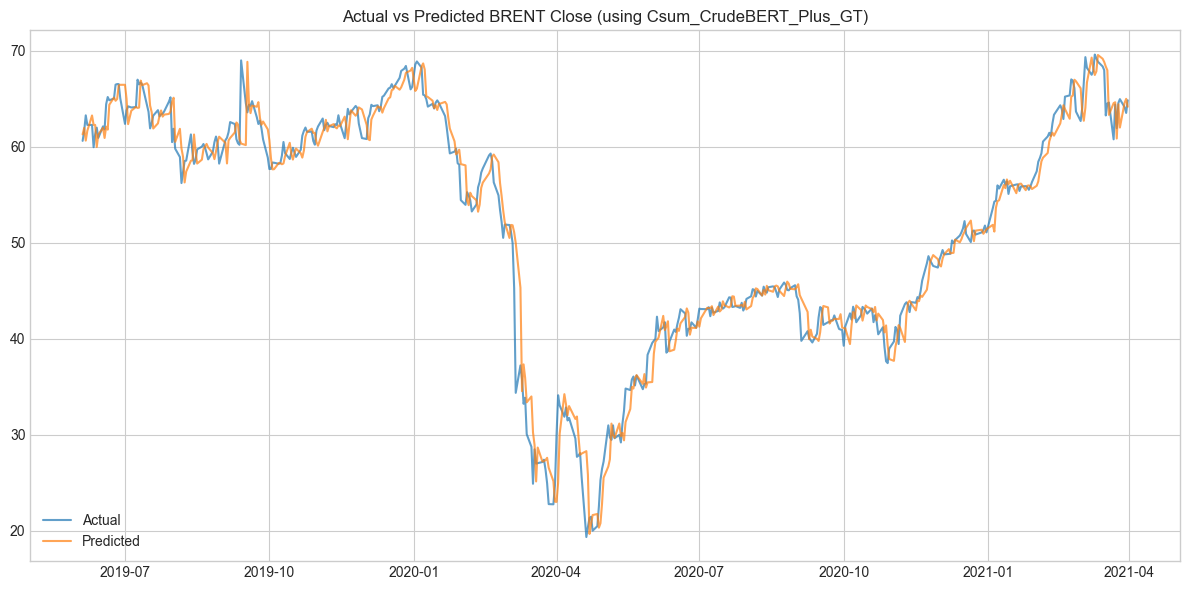


Feature importance in final model:


,Feature,Coefficient
3,BRENT Close_lag1,26.357118
2,Csum_CrudeBERT_Plus_GT_lag2,0.107151
1,Csum_CrudeBERT_Plus_GT_lag1,0.076121
4,BRENT Close_lag2,0.057572
0,Csum_CrudeBERT_Plus_GT,0.022561


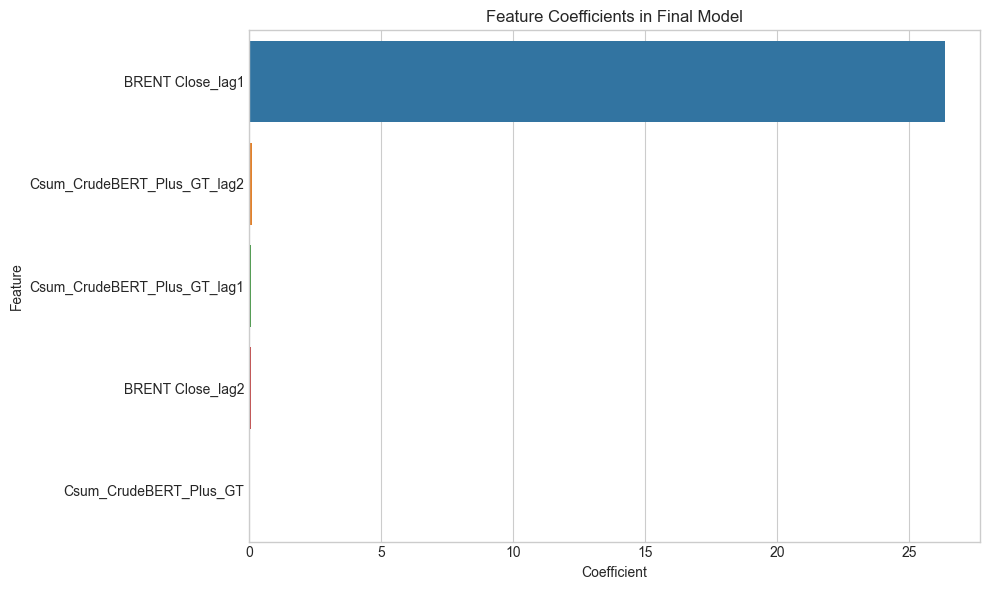

In [12]:
# Cell 10: Additional analysis - predictive model with the best sentiment
print("\n--- Building Predictive Model with Best Sentiment ---")

# Prepare data for the final model
df_clean = df_full.dropna(subset=[TARGET_COLUMN]).copy()
df_pred, _ = prepare_lagged_features(
    df_clean, [best_sentiment_col], TARGET_COLUMN, FORECAST_HORIZON
)

# Select features for the final model (best sentiment and target lags)
final_features = [
    best_sentiment_col, 
    f"{best_sentiment_col}_lag1",
    f"{best_sentiment_col}_lag2", 
    f"{TARGET_COLUMN}_lag1", 
    f"{TARGET_COLUMN}_lag2"
]
final_features = [f for f in final_features if f in df_pred.columns]

# Prepare data
X = df_pred[final_features]
y = df_pred['target']

# Split data into train and test (last 20% as test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the final model
if BEST_MODEL == 'lasso':
    final_model = LassoCV(cv=5, random_state=42, max_iter=2000)
elif BEST_MODEL == 'ridge':
    final_model = RidgeCV(cv=5)
elif BEST_MODEL == 'randomforest':
    final_model = RandomForestRegressor(n_estimators=100, random_state=42)
elif BEST_MODEL == 'gbm':
    final_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
else:
    final_model = LinearRegression()

final_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Final model performance on test set:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title(f'Actual vs Predicted {TARGET_COLUMN} (using {best_sentiment_col})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate feature importance for the final model
if BEST_MODEL in ['lasso', 'ridge']:
    try:
        coefs = final_model.coef_ if hasattr(final_model, 'coef_') else final_model.best_estimator_.coef_
        importance = pd.DataFrame({
            'Feature': final_features,
            'Coefficient': coefs
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        print("\nFeature importance in final model:")
        display(importance)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Coefficient', y='Feature', data=importance)
        plt.title('Feature Coefficients in Final Model')
        plt.tight_layout()
        plt.show()
    except:
        print("Could not extract coefficients from the model.")